In [23]:
import scipy
print('scipy: {}'.format(scipy.__version__)) # numpy
import numpy as np
print('numpy: {}'.format(np.__version__))
# matplotlib
import datetime


import matplotlib 
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__)) # pandas
import pandas as pd
print('pandas: {}'.format(pd.__version__))
#scikit-learn
import sklearn
print('sklearn: {}'.format(sklearn.__version__))
import xlrd
from sklearn.preprocessing import Imputer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso, Ridge  
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection #might be model_selection <--- this is the new one
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
import seaborn as sns
import xgboost as xgb
sns.set_style("whitegrid")
%matplotlib inline

scipy: 1.0.0
numpy: 1.12.1
matplotlib: 2.1.0
pandas: 0.21.1
sklearn: 0.19.1


In [24]:
pd.set_option("display.max_columns",500)

In [425]:
data = pd.read_csv('SuperZooData/Registration_Data/SuperZoo_2016_Registrants_No_Minors.csv', header = 2)

In [281]:
plotting = data['AddDate Date'].value_counts().sort_values(ascending=True)

In [292]:
plotting.index.sort_values(ascending=True)

Index([u'01/25/2016', u'01/26/2016', u'01/27/2016', u'01/28/2016',
       u'01/29/2016', u'01/30/2016', u'01/31/2016', u'02/01/2016',
       u'02/02/2016', u'02/03/2016',
       ...
       u'07/26/2016', u'07/27/2016', u'07/28/2016', u'07/29/2016',
       u'07/30/2016', u'07/31/2016', u'08/01/2016', u'08/02/2016',
       u'08/03/2016', u'08/04/2016'],
      dtype='object', length=193)

In [291]:
plotting

03/05/2016      9
03/12/2016     10
03/06/2016     10
04/09/2016     11
05/08/2016     14
03/19/2016     16
03/07/2016     18
02/21/2016     18
05/07/2016     18
02/07/2016     18
03/08/2016     18
02/20/2016     19
06/12/2016     19
03/13/2016     20
04/08/2016     21
04/17/2016     21
03/26/2016     21
01/30/2016     21
05/14/2016     21
04/30/2016     21
03/25/2016     21
05/21/2016     21
04/23/2016     22
04/10/2016     22
06/05/2016     23
06/04/2016     23
03/27/2016     23
05/28/2016     24
05/22/2016     24
04/15/2016     25
             ... 
05/31/2016    153
07/08/2016    153
06/06/2016    155
07/07/2016    168
01/25/2016    168
06/20/2016    170
07/11/2016    171
06/28/2016    174
01/27/2016    174
07/01/2016    175
07/14/2016    178
07/21/2016    192
07/22/2016    200
07/13/2016    202
01/26/2016    216
02/24/2016    232
07/12/2016    236
07/20/2016    241
07/31/2016    246
07/19/2016    250
08/03/2016    258
07/29/2016    268
07/27/2016    268
07/06/2016    278
07/25/2016

In [295]:
plt.figure(figsize=(150, 150))
plt.plot(plotting.index.sort_values(ascending=True), plotting)
plt.xticks(rotation='vertical')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [ ]:
df = df.sort_values('date', ascending=True)
plt.plot(df['date'], df['count'])
plt.xticks(rotation='vertical')

In [426]:
test_data = pd.read_csv('SuperZooData/Registration_Data/SuperZoo_2017_Registrants_No_Minors.csv', header = 2)

In [393]:
def dups_with_dif_index_check(data):
    dupes = {}                        # checks to see if duplicated columns with different index values
    for col_a in data.columns:
        dupes[col_a] = []

        for col_b in data.columns:
            if col_b in dupes.keys():
                continue
            if (data.loc[:,col_a] == data.loc[:,col_b]).sum() == len(data.loc[:,col_a]):
                dupes[col_a].append(col_b)    
   
    bad_cols = []   
    for col, dup_cols in dupes.iteritems():
        bad_cols += dup_cols
    bad_cols = set(bad_cols)

    data = data.loc[:,~data.columns.isin(bad_cols)]
    return data

In [394]:
def clear_dups_na(data):
    data = data.loc[:,~data.columns.duplicated()] 
    data = data.dropna(axis=1, how='all')
    data = data.dropna(axis=0, how='all')
    data = dups_with_dif_index_check(data)
    return data

In [395]:
def def_time_modify(data, date_checker):
    data["AddDate Date"] = pd.to_datetime(data["AddDate Date"])
    data['ModifyDate Date'] = pd.to_datetime(data['ModifyDate Date'])
    for a in range(0,len(data.iloc[:,data.columns.get_loc('ModifyDate Date')])):
        if data.iloc[a,data.columns.get_loc('ModifyDate Date')] > date_checker:
            data.iloc[a,data.columns.get_loc('ModifyDate Date')] = data.iloc[a,data.columns.get_loc("AddDate Date")]
   
    return data

In [396]:
def date_time_update(data, date_checker):
    data = data[data["AddDate Date"] <= date_checker]
    return data
    

In [397]:
def data_drop_other_text(data):
    col = []
    for a in data:
        if "_text" in a or "_other" in a:
            col.append(a)
    data=data.drop(labels = col, axis =1)
    return data

In [225]:
def get_rid_of_nonnumerical_answer(data):
    col = [] # THIS NEEDS TO BE CHANGED FOR NEW DATA SET
    checker = 1
    for a in data.columns:
        if '_codes' in a and checker ==1:
            checker = 0
        if '_codes' not in a and checker == 0:
            col.append(a)
    data = data.drop(col, axis = 1)
    return data

In [226]:
def answers_dummies(data):
    column =[]
    for a in data.columns:
        if "_codes" in a:
            column.append(a)  
    for a in column:
        new_data = data[a].str.get_dummies(sep=',')
        data = pd.concat([data, new_data], axis=1)
        data = data.drop([a], axis = 1)
    return data
    

In [227]:
def data_change_string_drop_dups(data):
    for a in data.columns:
        if data[a].dtype== np.dtype('O'):
            data[a] = data[a].astype('S32')
    cols = list(data)    # THIS DROPS ALL COLUMNS THAT HAVE THE SAME VALUE
    nunique = data.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    data = data.drop(cols_to_drop, axis=1)
    return data

In [228]:
def purchase_dummies(data):
    new_data = data['PurchaseItems'].str.get_dummies(sep=',')
    data = pd.concat([data, new_data], axis=1)
    data = data.drop(['PurchaseItems'], axis = 1)
    return data 

In [229]:
def state_dummies(data):
    s = data.State.value_counts()
    s = data.State.value_counts()[s > (8)].index #8
    holder = pd.get_dummies(data.State)
    holder_smaller = holder[s]
    data = pd.concat([data, holder_smaller], axis=1)
    return data

In [230]:
def email_change(data):
    for index, row in data.iterrows():
        try:
            data.loc[index, 'Email'] = data['Email'][index].split("@",1)[1]
        except:
            pass
    return data

In [231]:
def email_dummies(data):
    data = email_change(data)
    s = data.Email.value_counts()
    s = data.Email.value_counts()[s > (48)].index  #48
    holder = pd.get_dummies(data.Email)
    holder_smaller = holder[s]
    data = pd.concat([data, holder_smaller], axis=1)
    return data

In [246]:
def column_drops(data):
    data = data.drop(['WebUrl',"CheckInDate Date","Aux1", "Aux5","FirstPrintDate Time","FirstPrintLocId", 'FirstPrintStationId','CheckInDate Time',"ModifyDate Time", "IndexDate"], axis = 1)
    data = data.drop(['RegTypeDesc','SourceApp','CountryName','StreamSteps','StreamName', 'RegType','StreamStep',"AddUserId","ModifyUserId","AddDate Time"], axis = 1)
    data = data.drop(["Pwd", "UserName", "AccountKeyPublic","AccountKeyPrivate", "Notes",'Id', 'AccountId', 'ClientIp', 'StreamId','State', 'StreamStatus'], axis = 1)
    return data

In [247]:
def data_dummies(data):
    data = pd.get_dummies(data,columns = ['Aux6', 'ApprovalUserId', 'LangId', 'MemberStatus', 'TermsAccepted'], dummy_na = True)
    return data
    

In [248]:
def data_dummies_cleanup(data):
    d = {'3001': ['3001', '3001.1']}   
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    d = {'2001': ['2001', '2001.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    # renames duplicate column names
    d = {'TermsAccepted_nan': ['TermsAccepted_nan', 'TermsAccepted_nan.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    d = {'MemberStatus_nan': ['MemberStatus_nan', 'MemberStatus_nan.1']}
    data = data.rename(columns=lambda c: d[c].pop(0) if c in d.keys() else c)
    return data

In [429]:
def processing_data(data):
    date_checker = datetime.datetime(2017,7,13) #train_X 2016,5,31 2016,7,21    test_X 2017,5,23  2017,7,13   
    data = data.apply(pd.to_numeric, errors='ignore')
    data = clear_dups_na(data)
    print data.shape
    data = def_time_modify(data, date_checker)
    print data.shape
    data = date_time_update(data, date_checker)
    print data.shape
    data = data_drop_other_text(data)
    data = get_rid_of_nonnumerical_answer(data)
    data = answers_dummies(data)
    data = data_change_string_drop_dups(data)
    data = purchase_dummies(data)
    data = state_dummies(data)
    data = email_dummies(data)
    data = column_drops(data)
    data = data_dummies(data)
    data = data_dummies_cleanup(data)
    return data

In [428]:
data = processing_data(data)

(16253, 184)
(16253, 184)
(12564, 184)


In [430]:
test_data = processing_data(test_data)

(13444, 182)
(13444, 182)
(10242, 182)


In [431]:
data.to_pickle("Data_Zoo.pkl")

In [432]:
test_data.to_pickle("Data_Zoo_test.pkl")

In [463]:
data = pd.read_pickle("Data_Zoo.pkl")

In [464]:
test_data = pd.read_pickle("Data_Zoo_test.pkl")

In [435]:
test_data.shape

(10242, 347)

In [573]:
#(data.T.drop_duplicates(subset=data.index)).T  # to big of a dataset to use this to get rid of duplicate columns with different names

In [585]:
#for a in range(0,len(data.columns)):                                          # look at values of columns
#    if len(data.iloc[:,1])-data.iloc[:,a].isnull().sum() == 0:
#         print data.columns[a], len(data.iloc[:,1])-data.iloc[:,a].isnull().sum()

In [400]:
def day_to_event(data, test_data, date, test_date):
    data["Days_to_Event"] = (date - data['AddDate Date']).dt.days
    test_data["Days_to_Event"] = (test_date - test_data['AddDate Date']).dt.days
    return data, test_data

In [401]:
def day_to_event_modify(data, test_data, date, test_date):
    data["Days_to_Event_Modify"] = (date - data['ModifyDate Date']).dt.days
    test_data["Days_to_Event_Modify"] = (test_date - test_data['ModifyDate Date']).dt.days
    return data, test_data

In [402]:
def y_for_train(train_data):
    y =[]
    for a in train_data['FirstPrintDate Date']:
        if a == 'nan':
            y.append(0)
        else:
            y.append(1)
    return y

In [403]:
def y_for_test(test_data):
    y =[]
    for a in test_data['FirstPrintDate Date']:
        if a == 'nan':
            y.append(0)
        else:
            y.append(1)
    return y

In [404]:
def train_test_column_sync(data, test_data):
    col=[]
    for a in data.columns:
        for b in test_data.columns:
            if a == b:
                col.append(b)    
    return col

In [405]:
def data_impute(X):
    data_X_hold = X.columns
    imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
    imp.fit(X)
    data_T=imp.transform(X)
    X = pd.DataFrame(data_T, columns = data_X_hold)
    return X

In [406]:
def train_test_processing(data, test_data):
    date = datetime.datetime(2016,7,31)
    test_date = datetime.datetime(2017,7,23)
    train_Y = y_for_train(data)
    test_Y = y_for_test(test_data)
    data, test_data = day_to_event(data, test_data, date, test_date)
    data, test_data = day_to_event_modify(data, test_data, date, test_date)
    train_X = data.select_dtypes(include = ['int64', 'float64', 'uint8']).iloc[:, 1:]
    test_X = test_data.select_dtypes(include = ['int64', 'float64', 'uint8']).iloc[:, 1:]
    col = train_test_column_sync(train_X, test_X)
    train_X = data[col]
    test_X = test_data[col]
    train_X = data_impute(train_X)
    test_X = data_impute(test_X)
    return (train_X, train_Y, test_X, test_Y)

In [465]:
train_X, train_Y, test_X, test_Y = train_test_processing(data, test_data)

In [437]:
import pandas_ml as pdml
import imblearn

In [466]:
train_Y = pd.DataFrame(train_Y)

In [467]:
data_normalized = pd.concat([train_X, train_Y], axis = 1)


In [468]:
data_normalized = pdml.ModelFrame(data_normalized, target = 0)

In [469]:
sampler = data_normalized.imbalance.over_sampling.SMOTE()
sampled = data_normalized.fit_sample(sampler)
sampled=pd.DataFrame(sampled)

In [470]:
sampled = sampled.sample(frac=1)
train_Y = sampled[0]
train_X = sampled.drop([0], axis = 1)

In [452]:
for a in train_X.columns:
    print a

Phone2Number
FaxCountryPrefix
AmountBilled
AmountPaid
AmountDue
0201
0202
0203
0204
0205
0206
0207
0208
0209
0210
0211
0212
0213
0214
0215
0216
0217
0218
0219
0220
0221
0222
0223
0224
0225
0226
0227
0401
0402
0501
0502
0601
0602
0701
0702
1101
1103
1201
1301
1401
1501
1601
1801
1901
1902
2001
2101
2201
2202
2203
2301
2302
2304
2305
2307
2309
2310
2401
2402
2403
3001
3101
3102
3103
3201
3301
3401
3501
3601
3801
3802
3901
3902
4001
4101
4301
4302
4303
4304
4305
4306
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4321
4322
4323
4324
4325
4326
4327
4329
4330
4331
4701
4801
4901
5001
5002
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
2001.1
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015

In [471]:
train_T = train_X[['Days_to_Event','Days_to_Event_Modify','TermsAccepted_accepted']]

In [472]:
num_folds = 10
num_instances = len(train_T) 
seed = 7
scoring = 'roc_auc'

In [473]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier(n_neighbors =  25, weights = 'distance'))) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    cv_results = model_selection.cross_val_score(model, train_T, train_Y, cv=kfold, scoring= scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.674768 (0.012835)
NB: 0.634189 (0.014076)
KNeighborsClassifier: 0.719621 (0.004757)
XGBClassifier: 0.710901 (0.006371)
GradientBoostingClassifier: 0.714414 (0.006753)
AdaBoostClassifier: 0.681482 (0.007292)
RandomForestClassifier: 0.749352 (0.005131)
ExtraTreesClassifier: 0.755216 (0.006108)
DecisionTreeClassifier: 0.748087 (0.005301)


In [475]:
model = xgb.XGBClassifier()
model.fit(train_T, train_Y)
#test_preds = model.predict(test_X)
array = model.predict(train_T)
probab = model.predict_proba(train_T)


In [898]:
probab[3]

array([ 0.24021084,  0.75978916])

In [476]:
unique_elements, counts_elements = np.unique(array, return_counts=True)  # this is predictions
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[    0     1]
 [ 4002 11976]]


In [477]:
unique_elements, counts_elements = np.unique(train_Y, return_counts=True) #this is actual
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[   0    1]
 [7989 7989]]


In [479]:
from sklearn.metrics import confusion_matrix

In [480]:
confusion_matrix(train_Y, array)

array([[3350, 4639],
       [ 652, 7337]], dtype=int64)

In [258]:
estimator = xgb.XGBClassifier()
rfe = RFECV(estimator,cv = kfold)
fit = rfe.fit(train_X,train_Y)
print("Num of feature: %d") % fit.n_features_
#print("Selected features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num of feature: 65
Feature Ranking: [  1   1   1   1   1   1   1  12   1  25   1   1   1   1   1   1   1   1
   1   1   1   1   4  49   1   1   3   2  59   1   1   7  72  74  76  78
  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108 110 112 114
 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 145 139 146
 148  53   1  29  27 163  19   1 169 171   1 174 176 179 178 153 155 157
   1   5   1 180 182 184 185   1 189   1  30  32  18   1   1  48  36  37
  34  54  55  38   1  42  44  56  60  62  67  10 150 158 160 164 186 190
 192 194   8   1 200 202 203 204   9 208 210 212 214 216 218 220 222 224
 226 228 230 232 234 236 238 240 241 239 237 235 233 231 229 227 225 223
 221 219 217 215 213 211 209 207 201 199 177 175 173 137 135 133 131 129
 127 125 123 121 119 117 115 113 111 109 107 105 103 101  99  97  95  93
  91  89  87  85  83  81  79  77  75  73  71  68  69  70  13   1  52   1
   1   1   1   1   1   1   1   1 147   1 172 151   1  22   1 161   1  39
 166 167   6 18

In [259]:
top_65_important_features = [] 
for b in range(0,len(fit.ranking_)):
    if fit.ranking_[b] == 1:
        top_65_important_features.append(b)
        print b,train_X.columns[b]

0 Phone2Number
1 FaxCountryPrefix
2 AmountBilled
3 AmountPaid
4 AmountDue
5 0201
6 0202
8 0204
10 0206
11 0207
12 0208
13 0209
14 0210
15 0211
16 0212
17 0213
18 0214
19 0215
20 0216
21 0217
24 0220
25 0221
29 0225
30 0226
74 3801
79 4101
82 4303
90 4314
92 4316
97 4322
99 4324
103 4329
104 4330
112 1002
129 1019
213 ATL
215 CON
216 CA
217 NV
218 AZ
219 TX
220 CO
221 WA
222 UT
223 FL
225 NY
228 MO
230 NJ
232 ON
240 GA
242 NC
250 OK
257 IA
274 MS
276 gmail.com
277 yahoo.com
278 aol.com
279 hotmail.com
284 comcast.net
290 Aux6_1.0
291 Aux6_nan
292 ApprovalUserId_0.0
293 ApprovalUserId_20.0
295 LangId_0.0
302 TermsAccepted_accepted


In [260]:
new_X = train_X.iloc[:,top_65_important_features]

In [261]:
X = new_X

In [262]:
top_65_important_features = X

In [263]:
models=[]
models.append(('LR', LogisticRegression(random_state = seed)))
#models.append(('LASSO', Lasso())) 
#models.append(('Ridge', Ridge())) 
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNeighborsClassifier', KNeighborsClassifier())) 
models.append(('XGBClassifier', xgb.XGBClassifier()))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)))
#models.append(('SVC', SVC(kernel = 'linear', random_state = seed)))
#models.append(('LinearSVR', LinearSVR(random_state = seed)))
for name, model in models:
    kfold = model_selection.KFold(shuffle = True, n_splits=num_folds, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, train_Y, cv=kfold, scoring= scoring)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.526844 (0.010144)
NB: 0.486151 (0.009406)
KNeighborsClassifier: 0.722892 (0.007454)
XGBClassifier: 0.804854 (0.007700)
GradientBoostingClassifier: 0.807666 (0.007756)
AdaBoostClassifier: 0.772521 (0.008043)
RandomForestClassifier: 0.813782 (0.008067)
ExtraTreesClassifier: 0.806757 (0.007773)
DecisionTreeClassifier: 0.758981 (0.007442)


In [480]:
y_test = pd.DataFrame({'y': y})

In [271]:
Z=[]
Z=pd.concat([X,train_Y],axis=1)

In [272]:
corr = Z.select_dtypes(include = ['int64', 'float64','uint8']).iloc[:, 1:].corr()

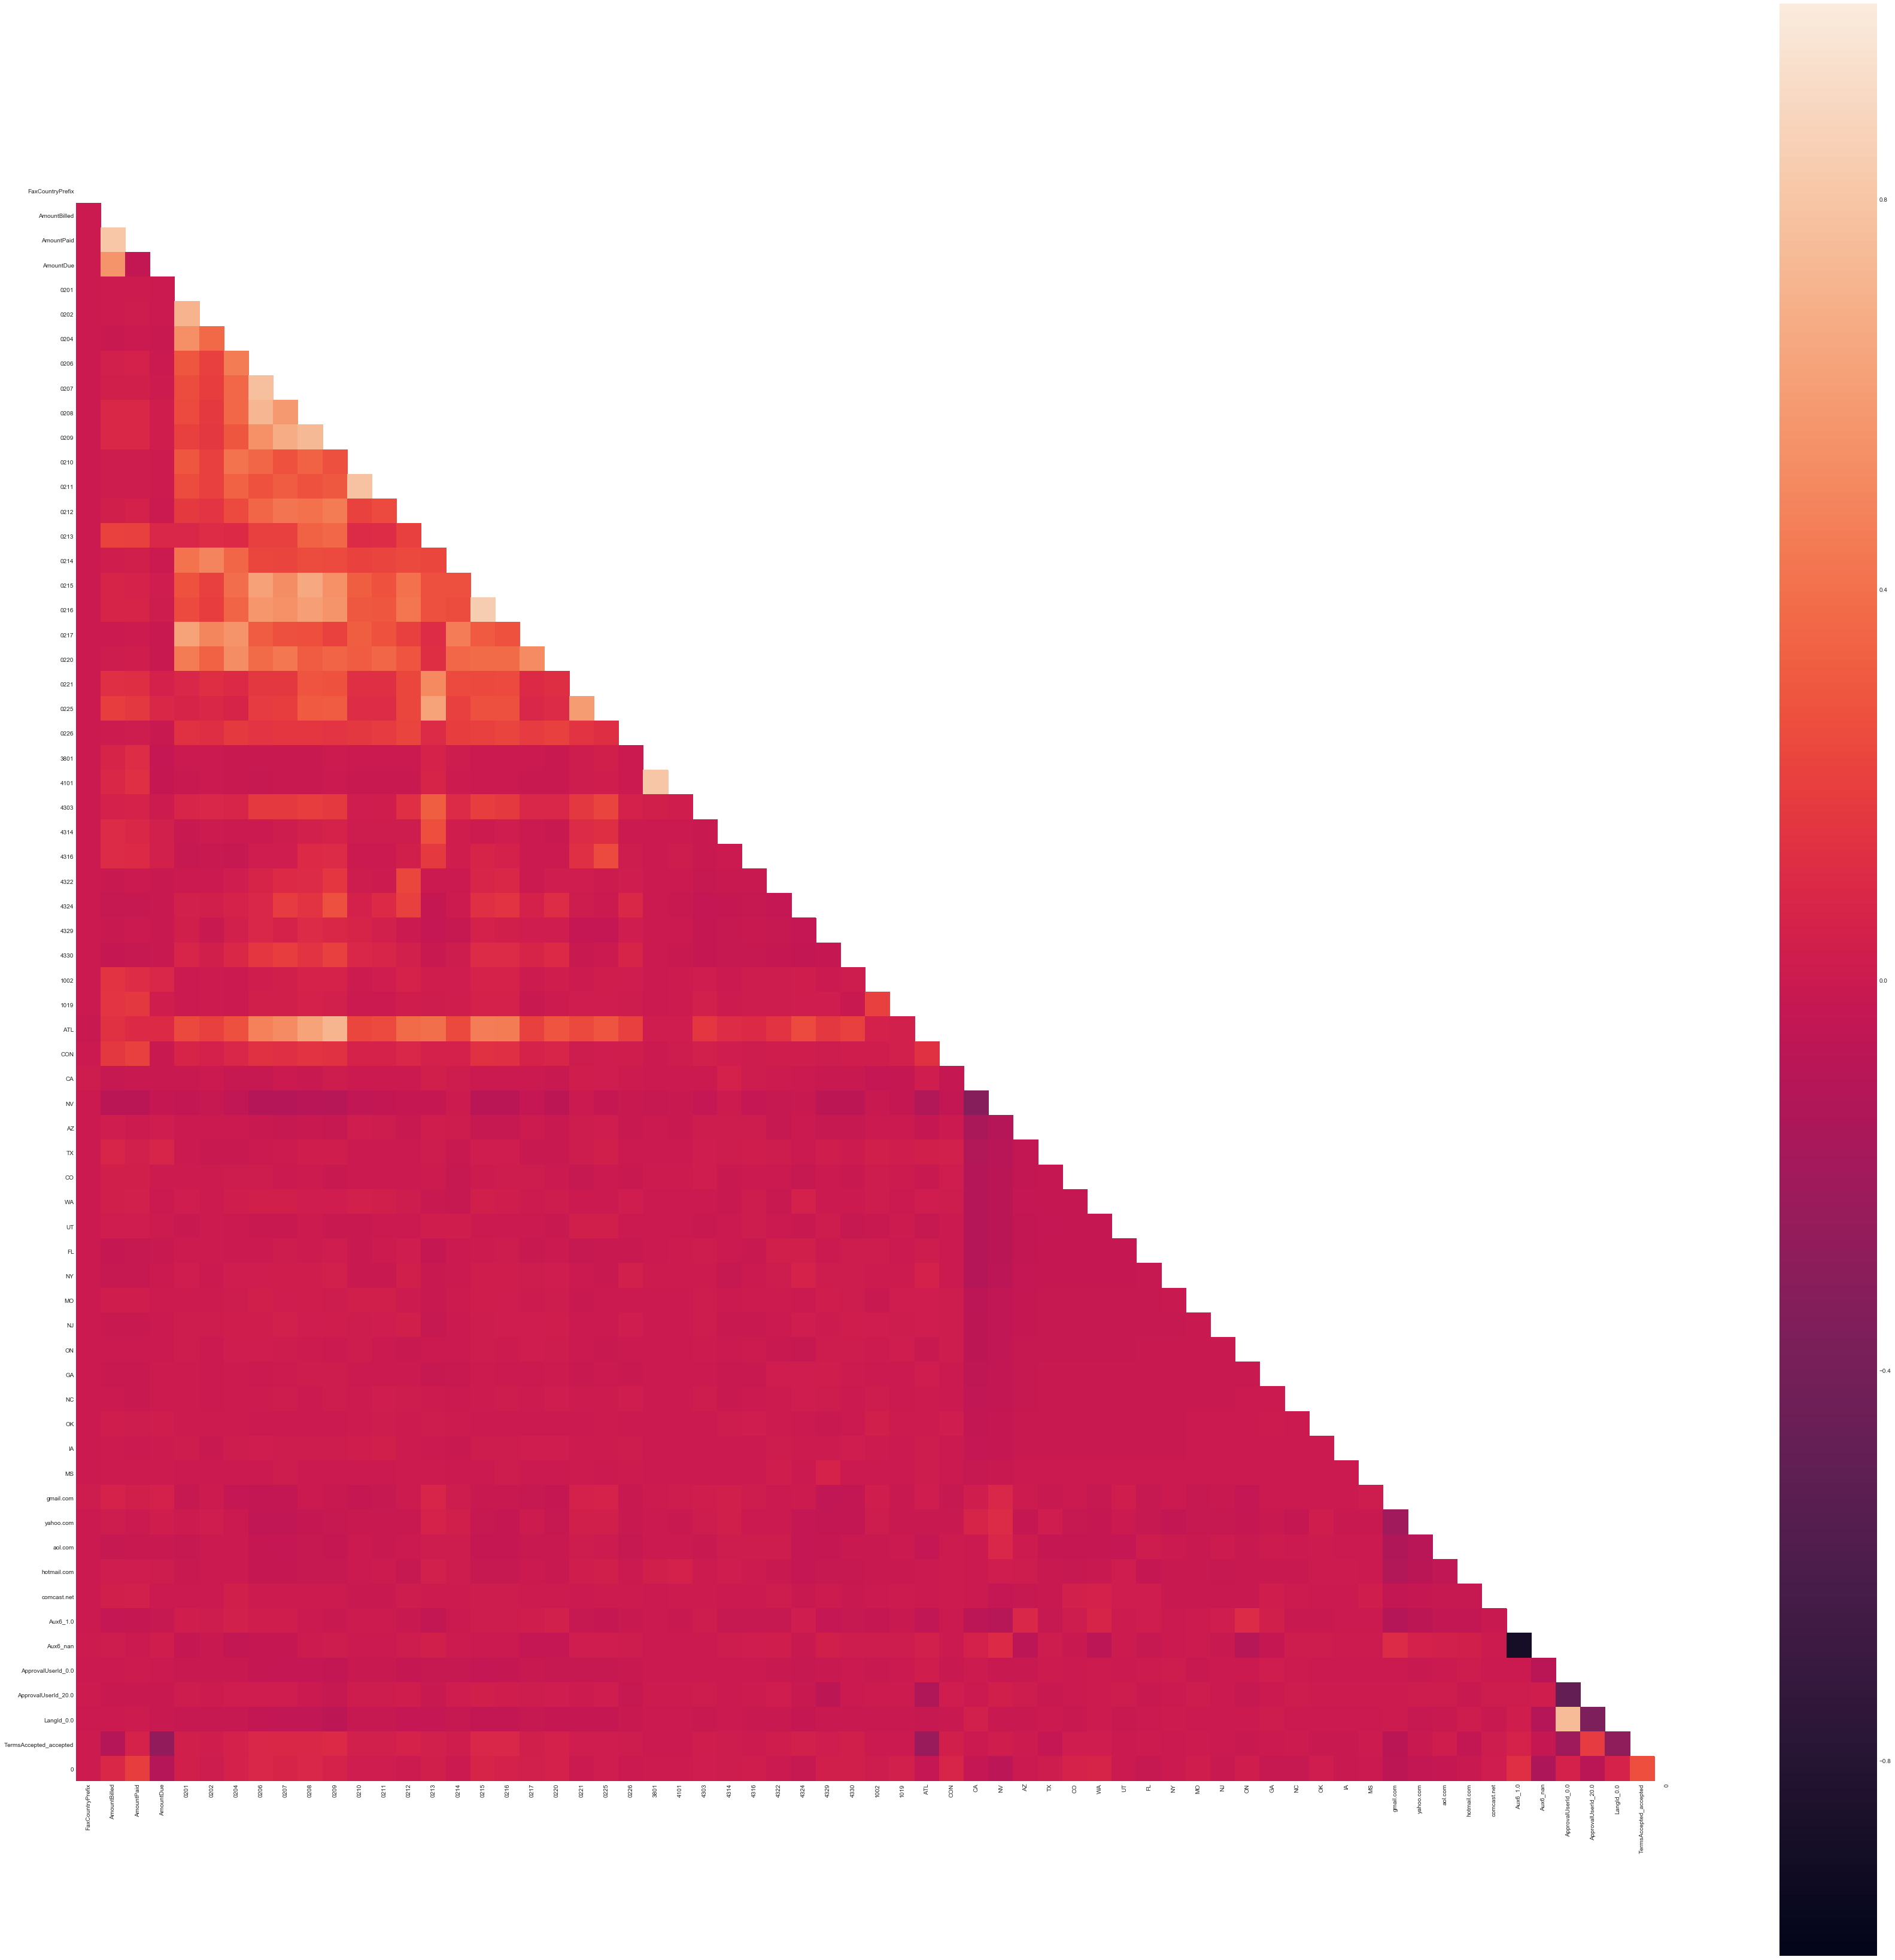

In [273]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(60, 60))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmin = -1, vmax=1, square=True)

In [112]:

pd.set_option('display.max_columns', 500)

In [237]:
for a in range(0, len(models)):
    model1 = models[a]
    for b in range(a+1, len(models)):
        model2 = models[b]
        for c in range(b+1, len(models)):
            model3 = models[c]
            estimators = []
            estimators.append(model1)
            estimators.append(model2)
            estimators.append(model3)
            ensemble = VotingClassifier(estimators, voting='soft')
            results = model_selection.cross_val_score(ensemble, X, train_Y, cv=kfold, scoring= scoring)
            if results.mean() > .80:
                print(model1[0], model2[0], model3[0],results.mean(), results.std())


('LR', 'NB', 'XGBClassifier', 0.80373094511182885, 0.0074459607933667054)
('LR', 'NB', 'GradientBoostingClassifier', 0.80713897061068562, 0.0078512408350388599)
('LR', 'NB', 'RandomForestClassifier', 0.82051366423957095, 0.0067826765094150905)
('LR', 'NB', 'ExtraTreesClassifier', 0.8174011703123345, 0.0049786257282491819)
('LR', 'CART', 'XGBClassifier', 0.80893673369267893, 0.0063677302385076193)
('LR', 'CART', 'GradientBoostingClassifier', 0.8094223329283613, 0.0062800044189039034)
('LR', 'CART', 'RandomForestClassifier', 0.81054208304468178, 0.0063486744935278751)
('LR', 'CART', 'ExtraTreesClassifier', 0.8067311720566579, 0.0050780211636971429)
('LR', 'KNeighborsClassifier', 'GradientBoostingClassifier', 0.80098194320036475, 0.006733224410853219)
('LR', 'KNeighborsClassifier', 'RandomForestClassifier', 0.80875876278133385, 0.0064720190280071286)
('LR', 'KNeighborsClassifier', 'ExtraTreesClassifier', 0.80984221464294848, 0.0048449848855204661)
('LR', 'XGBClassifier', 'GradientBoosting

('XGBClassifier', 'AdaBoostClassifier', 'ExtraTreesClassifier', 0.8375869972229445, 0.0044279915984344487)
('XGBClassifier', 'AdaBoostClassifier', 'DecisionTreeClassifier', 0.8091061747279259, 0.0063735618787067365)
('XGBClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 0.83796133242389548, 0.0049690712501052024)
('XGBClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier', 0.82323529869688239, 0.005714240227708384)
('XGBClassifier', 'ExtraTreesClassifier', 'DecisionTreeClassifier', 0.82500181372507164, 0.0043426218027075294)
('GradientBoostingClassifier', 'AdaBoostClassifier', 'RandomForestClassifier', 0.83500381217148389, 0.0064748257368083548)
('GradientBoostingClassifier', 'AdaBoostClassifier', 'ExtraTreesClassifier', 0.83827040315951185, 0.0045667986291722173)
('GradientBoostingClassifier', 'AdaBoostClassifier', 'DecisionTreeClassifier', 0.80958828161984786, 0.0063097297172309517)
('GradientBoostingClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier',

In [239]:
X.columns

Index([u'Phone2Number', u'FaxCountryPrefix', u'AmountBilled', u'AmountPaid',
       u'AmountDue', u'0201', u'0202', u'0203', u'0204', u'0205',
       ...
       u'Aux6_nan', u'ApprovalUserId_0.0', u'ApprovalUserId_20.0',
       u'LangId_0.0', u'LangId_1.0', u'MemberStatus_FullMember',
       u'MemberStatus_NonMember', u'MemberStatus_nan',
       u'TermsAccepted_accepted', u'TermsAccepted_nan'],
      dtype='object', length=206)

In [ ]:
RandomForestClassifier(random_state = seed)))
models.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))

In [485]:
test_P = test_X[['Days_to_Event','Days_to_Event_Modify','TermsAccepted_accepted']]

In [486]:
model = xgb.XGBClassifier()
model.fit(train_T,train_Y)
predict = model.predict(test_P)
probab = model.predict_proba(test_P)

In [487]:
print metrics.accuracy_score(test_Y, predict)
print metrics.roc_auc_score(test_Y, probab[:, 1])

0.744776410857
0.634940117857


0.4562631

In [105]:
c = 0
e = 0
for idx, val in enumerate(probab):
    if val[0] > .80:
        c += 1
        if test_Y[idx] == 0:
            print c, 0, idx, val[0]
        else: 
            e += 1
            print c, 0, idx, val[0], "error"
            
   
    if val[1] > .80:
        c += 1
        if test_Y[idx] == 1:
            print c, 1, idx, val[1]
        else:
            e += 1
            print c, 1, idx, val[1], "error"
print e
        


1 1 5 0.847049 error
2 1 15 0.871296
3 1 16 0.88311
4 1 20 0.838504
5 1 22 0.93254
6 1 24 0.820854 error
7 1 29 0.807138 error
8 0 31 0.978607
9 0 32 0.955083
10 1 34 0.853794
11 1 40 0.982154
12 1 41 0.941388
13 1 46 0.921173
14 1 50 0.922265
15 1 51 0.929648
16 1 56 0.802691
17 1 60 0.836638
18 1 63 0.853794
19 1 65 0.974193
20 1 66 0.949529
21 1 70 0.95783
22 1 73 0.877312
23 1 77 0.818903
24 1 81 0.829025 error
25 1 82 0.829025 error
26 1 83 0.913506
27 1 84 0.911524
28 1 85 0.874371
29 1 92 0.843353
30 1 96 0.910315
31 1 97 0.854876
32 1 98 0.921319
33 0 101 0.919966
34 1 102 0.899787
35 1 103 0.934357
36 1 106 0.906808
37 1 107 0.818296 error
38 1 110 0.977726
39 1 111 0.864123 error
40 1 117 0.813391
41 1 121 0.973356
42 1 122 0.903364
43 1 124 0.921209
44 1 127 0.927748
45 1 131 0.874517
46 1 134 0.949483
47 1 143 0.865657
48 1 149 0.906808 error
49 1 150 0.803939
50 1 151 0.909066
51 1 155 0.850986
52 1 158 0.90416
53 1 163 0.965762
54 1 166 0.940401 error
55 1 172 0.803677
56

427 1 1376 0.974193
428 1 1377 0.909066
429 1 1379 0.817294 error
430 1 1380 0.93068
431 1 1389 0.800837 error
432 1 1394 0.835413
433 1 1399 0.906906
434 1 1401 0.8467
435 1 1402 0.978667
436 1 1403 0.98548
437 1 1404 0.909471
438 1 1409 0.930255
439 1 1417 0.931238
440 1 1419 0.979949
441 1 1423 0.901058
442 1 1428 0.984603
443 0 1430 0.831513
444 1 1436 0.822571
445 1 1443 0.832414
446 1 1444 0.978392
447 1 1448 0.982991
448 1 1449 0.969391
449 1 1450 0.974035
450 1 1451 0.910315
451 1 1453 0.816975
452 1 1459 0.863642
453 1 1463 0.810626
454 1 1466 0.822571
455 1 1472 0.819017 error
456 1 1476 0.807689 error
457 1 1478 0.898758
458 1 1492 0.906584
459 1 1493 0.915733
460 1 1498 0.840885 error
461 1 1503 0.930783
462 1 1506 0.845417 error
463 1 1511 0.911081
464 1 1515 0.805725 error
465 1 1516 0.83505
466 1 1521 0.935332
467 1 1523 0.809095
468 1 1524 0.906412
469 0 1526 0.957857
470 1 1534 0.964806
471 1 1538 0.906808
472 1 1539 0.817841 error
473 0 1541 0.979777
474 1 1542 0.9058

903 1 2863 0.816983 error
904 1 2866 0.874899 error
905 1 2867 0.845589
906 1 2869 0.864564
907 1 2870 0.940371
908 1 2878 0.806334
909 1 2879 0.977726
910 0 2880 0.838408
911 1 2887 0.930584 error
912 1 2889 0.941968
913 1 2894 0.898009
914 1 2895 0.891663
915 1 2897 0.831049
916 1 2898 0.933572
917 1 2900 0.874517
918 1 2901 0.832964
919 1 2907 0.930228
920 1 2908 0.945135
921 1 2909 0.806122 error
922 1 2913 0.857975 error
923 1 2917 0.842596
924 1 2922 0.963284
925 1 2924 0.939193
926 1 2926 0.81491
927 1 2943 0.82765 error
928 1 2946 0.911512
929 1 2948 0.975758
930 1 2960 0.849082
931 1 2962 0.878082
932 1 2964 0.852051
933 1 2966 0.828036 error
934 1 2972 0.841513
935 1 2973 0.973333
936 1 2974 0.817841 error
937 1 2977 0.857543
938 1 2982 0.910555
939 1 2984 0.93719 error
940 1 2986 0.933363
941 1 2987 0.947515
942 1 2989 0.889795
943 1 2990 0.807933
944 1 2993 0.936388
945 1 2995 0.955148
946 1 2997 0.81082 error
947 1 2998 0.92605
948 0 2999 0.962256
949 1 3001 0.927393
950 1

1386 1 4299 0.924946
1387 1 4300 0.910555
1388 1 4303 0.822697 error
1389 1 4304 0.845391
1390 1 4306 0.926866
1391 1 4319 0.835027
1392 0 4321 0.805537
1393 1 4322 0.815386 error
1394 1 4351 0.883493
1395 1 4354 0.892624 error
1396 1 4358 0.882536
1397 1 4365 0.810586
1398 1 4368 0.825374
1399 1 4371 0.974808
1400 1 4378 0.979101
1401 1 4379 0.965369
1402 1 4389 0.814596
1403 1 4390 0.914944
1404 1 4391 0.801524 error
1405 1 4394 0.886012
1406 0 4395 0.867135 error
1407 1 4396 0.817257
1408 1 4397 0.806924 error
1409 1 4400 0.822571
1410 0 4410 0.961599
1411 1 4412 0.8171 error
1412 1 4416 0.963078
1413 1 4417 0.906146
1414 1 4419 0.890288
1415 1 4420 0.956413
1416 1 4422 0.834014
1417 1 4423 0.817546
1418 1 4425 0.836832
1419 1 4427 0.93435
1420 1 4428 0.820148
1421 1 4429 0.803735
1422 1 4430 0.89879
1423 1 4431 0.882536
1424 1 4433 0.910315
1425 1 4438 0.899496
1426 1 4441 0.93545
1427 1 4442 0.915733
1428 1 4449 0.906808
1429 1 4451 0.868764
1430 1 4456 0.931786
1431 1 4460 0.8225

1871 0 5912 0.801005
1872 1 5924 0.804321
1873 1 5925 0.802023 error
1874 1 5926 0.831393
1875 1 5927 0.853283 error
1876 1 5928 0.906797
1877 1 5935 0.920583
1878 1 5936 0.948598
1879 1 5938 0.840835
1880 1 5940 0.96461
1881 1 5942 0.905798
1882 1 5947 0.832562 error
1883 1 5951 0.809604 error
1884 1 5954 0.930669
1885 1 5958 0.922839
1886 1 5959 0.86535
1887 1 5963 0.804496
1888 1 5964 0.809206
1889 1 5966 0.878514
1890 1 5967 0.866546
1891 1 5970 0.943173 error
1892 1 5973 0.811348 error
1893 1 5974 0.971854
1894 1 5978 0.882812
1895 1 5979 0.8955
1896 1 5980 0.830594
1897 1 5981 0.805513
1898 1 5986 0.897834
1899 1 5989 0.944555
1900 1 5990 0.911512
1901 1 5991 0.960608
1902 1 5992 0.805565
1903 1 5994 0.808786
1904 1 5996 0.852559
1905 1 5997 0.96004
1906 1 5998 0.926787
1907 1 6000 0.911792
1908 1 6001 0.911792
1909 1 6005 0.815688 error
1910 1 6008 0.870731
1911 1 6010 0.886347
1912 1 6011 0.910315
1913 1 6013 0.977726
1914 1 6015 0.906808
1915 1 6017 0.912226
1916 1 6018 0.9119

2325 1 7256 0.873605
2326 1 7257 0.814663
2327 1 7262 0.987884
2328 1 7271 0.931745
2329 1 7273 0.952299
2330 1 7276 0.913506
2331 1 7278 0.8277 error
2332 1 7279 0.80498
2333 1 7283 0.977431
2334 1 7286 0.855238
2335 1 7287 0.834576
2336 0 7291 0.850493
2337 0 7292 0.850493
2338 1 7295 0.86445
2339 1 7297 0.948569
2340 1 7298 0.930228
2341 1 7299 0.935728
2342 1 7300 0.909066
2343 1 7303 0.931881
2344 1 7306 0.894029
2345 1 7310 0.927844
2346 1 7313 0.938876
2347 1 7315 0.827917 error
2348 1 7318 0.81712 error
2349 1 7319 0.919016
2350 1 7323 0.923912
2351 1 7324 0.805788 error
2352 1 7326 0.950677
2353 1 7335 0.936842
2354 1 7341 0.811332
2355 1 7344 0.97485
2356 1 7345 0.982619
2357 1 7352 0.906808
2358 1 7353 0.802901
2359 1 7357 0.803006 error
2360 1 7358 0.818695
2361 1 7361 0.845589
2362 1 7362 0.847896 error
2363 1 7367 0.832082
2364 1 7373 0.959449
2365 1 7376 0.92611
2366 1 7378 0.973333
2367 1 7385 0.816126
2368 1 7389 0.925469
2369 1 7392 0.90456
2370 1 7413 0.973035
2371 1

2807 1 8648 0.885008
2808 1 8649 0.806169
2809 1 8650 0.810895
2810 1 8656 0.808408
2811 1 8657 0.822571
2812 1 8658 0.938423
2813 1 8673 0.813284 error
2814 1 8675 0.973456
2815 1 8681 0.85207
2816 1 8682 0.912137
2817 1 8687 0.973711
2818 1 8689 0.927754 error
2819 1 8690 0.973333
2820 1 8691 0.973401
2821 1 8693 0.973456
2822 1 8697 0.847141
2823 1 8701 0.92225
2824 0 8706 0.816212
2825 1 8707 0.982154
2826 1 8708 0.947003
2827 1 8715 0.969917
2828 1 8718 0.909066
2829 1 8719 0.975166
2830 0 8720 0.950199
2831 1 8722 0.909471
2832 1 8724 0.821386
2833 1 8727 0.846557 error
2834 1 8732 0.915733
2835 1 8736 0.847998 error
2836 1 8739 0.906808
2837 1 8742 0.911453
2838 1 8743 0.878145
2839 1 8746 0.810492 error
2840 1 8750 0.845589
2841 1 8754 0.985908
2842 1 8775 0.818695
2843 1 8776 0.975758
2844 1 8777 0.922501
2845 1 8779 0.800968
2846 1 8781 0.909464
2847 1 8784 0.867238
2848 1 8788 0.814596
2849 1 8791 0.830298
2850 1 8792 0.839518 error
2851 0 8793 0.8649
2852 1 8795 0.977927
28

3206 1 9975 0.979539
3207 1 9976 0.969412
3208 1 9979 0.918132
3209 1 9980 0.954677
3210 1 9983 0.988629
3211 1 9991 0.893304
3212 1 9994 0.903906
3213 1 9995 0.855068 error
3214 1 9997 0.90372
3215 1 10007 0.962985
3216 1 10008 0.822697
3217 1 10013 0.954383
3218 1 10020 0.804161
3219 1 10023 0.905805
3220 1 10031 0.830396
3221 1 10040 0.816126
3222 1 10043 0.837016
3223 1 10047 0.811426
3224 1 10049 0.951551
3225 1 10052 0.917924
3226 1 10055 0.914817
3227 1 10056 0.948252
3228 1 10058 0.850278 error
3229 1 10062 0.81241
3230 1 10064 0.986571
3231 1 10065 0.909066
3232 1 10067 0.987198
3233 1 10069 0.811512
3234 1 10070 0.816381 error
3235 1 10071 0.811649
3236 1 10074 0.927393
3237 0 10075 0.967538
3238 1 10077 0.976321
3239 1 10082 0.8171
3240 1 10084 0.975542
3241 1 10085 0.920521
3242 0 10087 0.845534
3243 1 10089 0.973333
3244 1 10090 0.939157
3245 1 10094 0.963536
3246 1 10096 0.922232
3247 1 10097 0.910372
3248 1 10099 0.974354
3249 0 10101 0.801005
3250 1 10102 0.96756
3251 0

3690 1 11460 0.898313
3691 1 11461 0.926338
3692 1 11470 0.915733
3693 1 11472 0.962035
3694 1 11473 0.818799
3695 0 11476 0.805968
3696 0 11485 0.979782
3697 0 11486 0.964405
3698 1 11488 0.813518
3699 1 11494 0.834894 error
3700 1 11497 0.850361
3701 1 11500 0.80375 error
3702 0 11501 0.968078
3703 1 11504 0.895669
3704 1 11508 0.80375
3705 0 11509 0.828925 error
3706 0 11510 0.962563
3707 1 11521 0.972092
3708 1 11522 0.913506
3709 1 11523 0.817841 error
3710 1 11542 0.940196
3711 1 11543 0.982619
3712 1 11544 0.975849
3713 1 11545 0.898674
3714 1 11549 0.809602
3715 1 11551 0.904321
3716 1 11552 0.969944
3717 1 11554 0.927817
3718 1 11560 0.817088
3719 1 11561 0.834819
3720 1 11562 0.933585
3721 1 11565 0.925962
3722 1 11572 0.943385
3723 1 11574 0.835415 error
3724 1 11576 0.915733
3725 1 11581 0.97485
3726 1 11582 0.860582
3727 1 11584 0.803676
3728 0 11586 0.919966
3729 1 11593 0.886012
3730 1 11596 0.822697
3731 1 11598 0.987078
3732 0 11604 0.859073
3733 1 11605 0.966885
3734 

4181 1 12984 0.801053
4182 1 12987 0.8166
4183 1 12994 0.801
4184 1 13000 0.86824
4185 1 13001 0.821792
4186 1 13005 0.8171
4187 0 13007 0.947809
4188 0 13011 0.967171
4189 1 13012 0.816652
4190 1 13014 0.80562 error
4191 1 13016 0.952898
4192 1 13019 0.915639
4193 1 13021 0.968758
4194 1 13026 0.830171 error
4195 1 13028 0.901141 error
4196 1 13031 0.810712
4197 1 13037 0.92076
4198 1 13038 0.82764
4199 1 13048 0.880541
4200 1 13049 0.836196 error
4201 1 13054 0.906808
4202 1 13057 0.806744
4203 1 13061 0.816381
4204 1 13066 0.915104
4205 1 13067 0.80423 error
4206 1 13069 0.915104
4207 1 13070 0.905805
4208 1 13072 0.811453
4209 1 13075 0.941053
4210 1 13081 0.909066
4211 1 13084 0.887654
4212 1 13087 0.913506
4213 1 13088 0.975472
4214 1 13089 0.848512
4215 1 13098 0.841959 error
4216 1 13100 0.804171
4217 1 13104 0.877586
4218 1 13106 0.975053
4219 1 13110 0.812067
4220 1 13112 0.81391 error
4221 1 13113 0.950355
4222 1 13116 0.975349
4223 1 13120 0.817189
4224 1 13124 0.821323
422

In [65]:
from sklearn import metrics

In [240]:
estimators = []
estimators.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)))
estimators.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)))
estimators.append(('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)))
ensemble = VotingClassifier(estimators, voting='soft')
ensemble.fit(X, train_Y)
predict = ensemble.predict(test_X[X.columns])
probab = ensemble.predict_proba(test_X[X.columns])

In [420]:
print metrics.accuracy_score(test_Y, predict)
print metrics.roc_auc_score(test_Y, probab[:, 1])

0.615331650218


ValueError: Found input variables with inconsistent numbers of samples: [4357, 7616]

In [489]:
print metrics.confusion_matrix(test_Y, predict)
#print metrics.classification_report(test_Y, predict)

[[1020 2096]
 [ 518 6608]]
